# Preliminaries

In [3]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.stats as stats
from scipy.stats import skew, kurtosis
from tqdm.notebook import tqdm
import datetime
from pandas_datareader import data as pdr
import yfinance as yf
np.random.seed(42)

# Google stock data

In [5]:
yf.pdr_override()
start = datetime.datetime(2021, 1, 1)
end = datetime.datetime(2022, 1, 1)
googlframe = pdr.get_data_yahoo("GOOGL", start="2020-01-01", end="2021-01-01")
display(googlframe.head())
display(googlframe.tail())

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,67.420502,68.433998,67.324501,68.433998,68.433998,27278000
2020-01-03,67.400002,68.687500,67.365997,68.075996,68.075996,23408000
2020-01-06,67.581497,69.916000,67.550003,69.890503,69.890503,46768000
2020-01-07,70.023003,70.175003,69.578003,69.755501,69.755501,34330000
2020-01-08,69.740997,70.592499,69.631500,70.251999,70.251999,35314000


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-24,86.449997,87.120499,86.217499,86.708000,86.708000,9312000
2020-12-28,87.245499,89.349998,87.091003,88.697998,88.697998,27650000
2020-12-29,89.361504,89.423500,87.755501,87.888000,87.888000,19726000
2020-12-30,88.250000,88.388000,86.400002,86.812500,86.812500,21026000
2020-12-31,86.863503,87.875000,86.804497,87.632004,87.632004,21070000


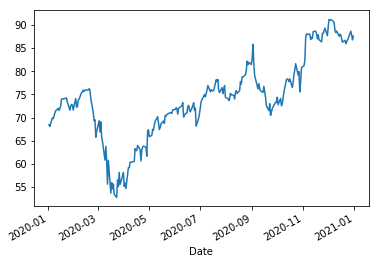

In [4]:
googlframe['Adj Close']['2020-01-01':'2021-01-01'].plot()

# SDE

$d S_{t}= r S_{t} d t+\sigma S_{t} dW_{t}$

In [4]:
from numpy import sqrt, exp, cumsum, sum, maximum, mean
from numpy.random import standard_normal

# Parameters

In [5]:
S0 = 87.63   # initial price
K = 100      # strike price
r = 0.01     # risk-free interest rate
sigma = 0.15 # volatility
T = 1        # time to maturity in years
N = 1000     # number of time steps
dt = T/N     # time step size
M = 1000     # number of simulations

# Base class for random walk models

In [6]:
class BaseSimulator:
    def __init__(self, model_name, S0, K, r, sigma, T, N, M, phis=[]):
        self.model_name = model_name
        self.S0 = S0  # initial price
        self.K = K    # strike price
        self.r = r    # risk-free interest rate
        self.sigma = sigma # volatility
        self.T = T    # time to maturity in years
        self.N = N    # number of time steps
        self.dt = T/N # time step size
        self.M = M    # number of simulations
        self.realisations = []  # full path of realisations
        self.expiry_prices = [] # expiry prices
        self.phis = phis # sequence of noise
 
    def run_monte_carlo(self):
        raise NotImplementedError("Subclass must implement abstract method")
    
    def plot_n_realisations(self, n):
        x = np.linspace(0.0, self.T, self.N+1)
        for i in range(n):
            plt.plot(x, self.realisations[:,i])
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title(f'Simulated Time Series using {self.model_name} method')
        plt.show()

# Euler-Maruyama method

$S_T=S_0 \exp \left\{\left(r-\frac{1}{2} \sigma^2\right) T+\sigma \phi \sqrt{T}\right\}$  
This is a closed form solution where the final price at expiry can be calculated in one giant step T.  
Integrated over [0,T]

In [7]:
# initialise random values
phi = standard_normal(M)

# Simulate I outcome
S = S0 * exp((r - 0.5 * sigma ** 2) * T + sigma * sqrt(T) * phi)
payoffs = maximum(S-K, 0)

# Calculate the Monte Carlo estimator
C0 = exp(-r * T) * sum(payoffs)/len(payoffs)
print("Estimated present value is %f" % C0)

Estimated present value is 1.687762


# Forward Euler-Maruyama method - slow
$S_{t+\delta t} = S_t(1+r \delta t+\sigma \phi \sqrt{\delta t})$

In [8]:
# function to run one simulation
def simulate_Euler_Maruyama():
    # Initialize the time series
    S = np.zeros(N+1)
    S[0] = S0
    
    # perform one realisation
    for i in range(N):
        _phi = np.random.normal(0, 1)
        S[i+1] = S[i] * (1 + r*dt + sigma*_phi*sqrt(dt))
    return S[-1]

start_time = time.time()
payoffs = maximum(np.array([simulate_Euler_Maruyama() for i in range(M)]) - K, 0)
option_price = exp(-r*T) * sum(payoffs)/len(payoffs)
print("Estimated present value is %f" % option_price)
print("Computation time is: ", round(time.time() - start_time,4))

Estimated present value is 1.545735
Computation time is:  5.0895


In [9]:
class Euler_Maruyama_simulator:
    def __init__(self, S0, K, r, sigma, T, N, M):
        self.S0 = S0
        self.K = K    # strike price
        self.r = r    # risk-free interest rate
        self.sigma = sigma # volatility
        self.T = T    # time to maturity in years
        self.N = N    # number of time steps
        self.dt = T/N # time step size
        self.M = M    # number of simulations
        self.realisations = [] # full path of realisations
        self.expiry_price = [] # expiry prices
        
    def perform_realisation(self):
        # Initialize the time series
        S = np.zeros(self.N+1)
        S[0] = self.S0

        # perform one realisaztion
        for i in range(self.N):
            _phi = np.random.normal(0, 1)
            S[i+1] = S[i] * (1 + self.r*self.dt + self.sigma*_phi*sqrt(self.dt))
        self.realisations.append(S)
        self.expiry_price.append(S[-1])
    
    def run_monte_carlo(self):
        for i in range(self.M) : self.perform_realisation()
        payoffs = maximum(np.array(self.expiry_price) - self.K, 0)
        option_price = exp(-self.r*self.T) * sum(payoffs)/len(payoffs)
        return option_price
    
    def plot_n_realisations(self, n):
        x = np.linspace(0.0, self.T, self.N+1)
        for i in range(n):
            plt.plot(x, self.realisations[i])
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title('Simulated Time Series using Euler-Maruyama method')
        plt.show()

In [10]:
start_time = time.time()
EM_simulator = Euler_Maruyama_simulator(S0, K, r, sigma, T, N, M)
EM_option_price = EM_simulator.run_monte_carlo()
print("Estimated present value is %f" % EM_option_price)
print("Computation time is: ", round(time.time() - start_time,4))

Estimated present value is 1.614720
Computation time is:  4.956


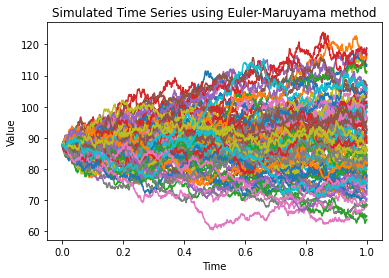

In [11]:
EM_simulator.plot_n_realisations(100)

# Forward Euler-Maruyama method - optimised
$S_{t+\delta t} = S_t(1+r \delta t+\sigma \phi \sqrt{\delta t})$

In [12]:
class Euler_Maruyama_fast_simulator(BaseSimulator):
    def run_monte_carlo(self):
        # initialise arrays of random variables
        if (len(self.phis) == 0):
            self.phis = standard_normal(size=(self.N, self.M))

        # perform simulations across each time steps
        delta_St = 1 + self.r*self.dt + self.sigma*np.sqrt(self.dt)*self.phis
        self.realisations = self.S0*np.cumprod(delta_St, axis=0)
        
        # prepend initial price S0 to the realisations
        self.realisations = np.concatenate((np.full(shape=(1, self.M), fill_value=self.S0), self.realisations))
        
        # calculate payoffs and dicounted option price
        self.expiry_prices = self.realisations[-1]
        payoffs = maximum(self.expiry_prices - self.K, 0)
        option_price = exp(-self.r*self.T) * sum(payoffs)/self.M
        return option_price

In [13]:
start_time = time.time()
em_simulator = Euler_Maruyama_fast_simulator("Euler-Maruyama", S0, K, r, sigma, T, N, M)
em_option_price = em_simulator.run_monte_carlo()
print("Estimated present value is %f" % em_option_price)
print("Computation time is: ", round(time.time() - start_time,4))

Estimated present value is 1.758084
Computation time is:  0.1383


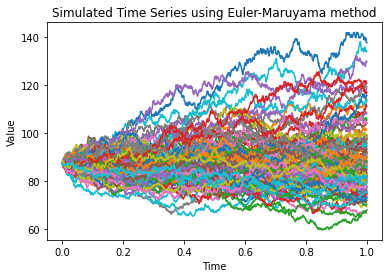

In [14]:
em_simulator.plot_n_realisations(100)

# Milstein method - slow
$S_{t+\delta t} = S_t\left(1+r \delta t+\sigma \phi \sqrt{\delta t}+\frac{1}{2} \sigma^2\left(\phi^2-1\right) \delta t\right)$

In [15]:
# function to run one simulation
def simulate_Milstein():
    # Initialize the time series
    S = np.zeros(N+1)
    S[0] = S0
    
    # perform one realisaztion
    for i in range(N):
        _phi = np.random.normal(0, 1)
        S[i+1] = S[i] * (1 + r*dt + sigma*_phi*sqrt(dt) + 0.5*(sigma**2)*(_phi**2 - 1)*dt)
    return S[-1]

start_time = time.time()
payoffs = maximum(np.array([simulate_Milstein() for i in range(M)]) - K, 0)
option_price = exp(-r*T) * sum(payoffs)/len(payoffs)
print("Estimated present value is %f" % option_price)
print("Computation time is: ", round(time.time() - start_time,4))

Estimated present value is 1.877610
Computation time is:  5.7028


In [16]:
class Milstein_simulator:
    def __init__(self, S0, K, r, sigma, T, N, M):
        self.S0 = S0
        self.K = K    # strike price
        self.r = r    # risk-free interest rate
        self.sigma = sigma # volatility
        self.T = T    # Final time
        self.N = N    # number of time steps
        self.dt = T/N # time step size
        self.M = M    # number of simulations
        self.realisations = []  # full paths of realisations
        self.expiry_prices = [] # expiry prices
        
    def perform_realisation(self):
        # Initialise the time series
        S = np.zeros(self.N+1)
        S[0] = self.S0

        # perform one realisaztion
        for i in range(self.N):
            _phi = np.random.normal(0, 1)
            S[i+1] = S[i] * (1 + self.r*self.dt + self.sigma*_phi*sqrt(self.dt) + 0.5*(self.sigma**2)*(_phi**2 - 1)*self.dt)
        self.realisations.append(S)
        self.expiry_prices.append(S[-1])
    
    def run_monte_carlo(self):
        for i in range(self.M) : self.perform_realisation()
        payoffs = maximum(np.array(self.expiry_prices) - K, 0)
        option_price = exp(-self.r*self.T) * sum(payoffs)/len(payoffs)
        return option_price
    
    def plot_n_realisations(self, n):
        x = np.linspace(0.0, self.T, self.N+1)
        for i in range(n):
            plt.plot(x, self.realisations[i])
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title('Simulated Time Series using Milstein method')
        plt.show()

In [17]:
start_time = time.time()
M_simulator = Milstein_simulator(S0, K, r, sigma, T, N, M)
M_option_price = M_simulator.run_monte_carlo()
print("Estimated present value is %f" % M_option_price)
print("Computation time is: ", round(time.time() - start_time,4))

Estimated present value is 1.416357
Computation time is:  5.9576


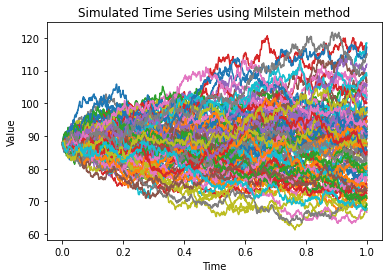

In [18]:
M_simulator.plot_n_realisations(100)

# Milstein method - optimised
$S_{t+\delta t} = S_t\left(1+r \delta t+\sigma \phi \sqrt{\delta t}+\frac{1}{2} \sigma^2\left(\phi^2-1\right) \delta t\right)$

In [21]:
class Milstein_fast_simulator(BaseSimulator):
    def run_monte_carlo(self):
        # initialise arrays of random variables
        if (len(self.phis) == 0):
            self.phis = standard_normal(size=(self.N, self.M))

        # perform simulations across each time steps
        delta_St = 1 + self.r*self.dt + self.sigma*np.sqrt(self.dt)*self.phis + 0.5*(self.sigma**2)*(np.square(self.phis)-1)*self.dt
        self.realisations = self.S0*np.cumprod(delta_St, axis=0)
        
        # prepend initial price S0 to the realisations
        self.realisations = np.concatenate((np.full(shape=(1, self.M), fill_value=self.S0), self.realisations))
        
        # calculate payoffs and dicounted option price
        self.expiry_prices = self.realisations[-1]
        payoffs = maximum(self.expiry_prices - self.K, 0)
        option_price = exp(-self.r*self.T) * sum(payoffs)/self.M
        return option_price

In [22]:
start_time = time.time()
mil_simulator = Milstein_fast_simulator("Milstein", S0, K, r, sigma, T, N, M)
mil_option_price = mil_simulator.run_monte_carlo()
print("Estimated present value is %f" % mil_option_price)
print("Computation time is: ", round(time.time() - start_time,4))

Estimated present value is 1.897618
Computation time is:  0.0766


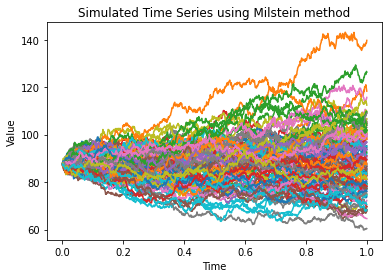

In [23]:
mil_simulator.plot_n_realisations(100)

# Monte Carlo Simulator
The same set of phis is used for both Euler-Maruyama and Milstein methods for comparison.

In [24]:
class MC_simulator:
    def __init__(self, S0, K, r, sigma, T, N, I):
        self.S0 = S0  # initial asset price
        self.K = K    # strike price
        self.r = r    # risk-free interest rate
        self.sigma = sigma # volatility
        self.T = T    # Final time
        self.N = N    # number of time steps
        self.dt = T/N # time step size
        self.I = I    # number of simulations
        self.Milstein_realisations = [] # full path of realisations using Milstein
        self.Milstein_expiry_prices = []
        self.Euler_Maruyama_realisations = [] # full path of realisations using Euler Maruyama
        self.Euler_Maruyama_expiry_prices = []
        self.phis = None # sequence of noise
    
    def perform_Euler_Maruyama_realisation(self):
        # Initialize the time series
        S = np.zeros(self.N+1)
        S[0] = self.S0

        # perform one realisation
        for i in range(self.N):
            S[i+1] = S[i] * (1 + self.r*self.dt + self.sigma*self.phis[i]*sqrt(self.dt))
        self.Euler_Maruyama_realisations.append(S)
        self.Euler_Maruyama_expiry_prices.append(S[-1])
        
    def perform_Milstein_realisation(self):
        # Initialize the time series
        S = np.zeros(self.N+1)
        S[0] = self.S0

        # perform one realisation
        for i in range(self.N):
            S[i+1] = S[i] * (1 + self.r*self.dt + sigma*self.phis[i]*sqrt(self.dt) + 0.5*(self.sigma**2)*(self.phis[i]**2 - 1)*self.dt)
        self.Milstein_realisations.append(S)
        self.Milstein_expiry_prices.append(S[-1])
    
    def calculate_option_price(self, expiry_prices):
        payoffs = maximum(np.array(expiry_prices) - self.K, 0)
        option_price = exp(-self.r*self.T) * sum(payoffs)/len(payoffs)
        return option_price
        
    def run_monte_carlo(self):
        # Run I number of simulations
        print('Start running simulations...')
        for i in tqdm(range(self.I)):
            self.phis = standard_normal(self.N)
            self.perform_Euler_Maruyama_realisation()
            self.perform_Milstein_realisation()
        
        # price the option
        EM_option_price = self.calculate_option_price(self.Euler_Maruyama_expiry_prices)
        M_option_price = self.calculate_option_price(self.Milstein_expiry_prices)
        return (EM_option_price, M_option_price)
    
    def plot_n_realisations(self, n):
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 6))
        # plots Euler-Maruyama realisations
        x = np.linspace(0.0, self.T, self.N+1)
        for i in range(n):
            axes[0].plot(x, self.Euler_Maruyama_realisations[i])   
        axes[0].set_xlabel('Time')
        axes[0].set_ylabel('Value')
        axes[0].set_title('Simulated Time Series using Euler-Maruyama method')
        
        # plots Milstein realisations
        for i in range(n):
            axes[1].plot(x, self.Milstein_realisations[i])   
        axes[1].set_xlabel('Time')
        axes[1].set_ylabel('Value')
        axes[1].set_title('Simulated Time Series using Milstein method')
        
        fig.tight_layout()
        plt.show()
    
    def comparing_ith_realisations(self, ith_rls):
        x = np.linspace(0.0, self.T, self.N+1)
        plt.figure(figsize=(13, 6))
        plt.plot(x, self.Euler_Maruyama_realisations[ith_rls], label='Euler-Maruyama')
        plt.plot(x, self.Milstein_realisations[ith_rls], label='Milstein')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title('Comparing Simulated Time Series using both methods')
        plt.legend()
        plt.show()

## optimised Monte Carlo simulator

In [25]:
class MC_simulator_optimised:
    def __init__(self, S0, K, r, sigma, T, N, M, phis=[]):
        self.S0 = S0  # initial asset price
        self.K = K    # strike price
        self.r = r    # risk-free interest rate
        self.sigma = sigma # volatility
        self.T = T    # Final time
        self.N = N    # number of time steps
        self.dt = T/N # time step size
        self.M = M    # number of simulations
        self.phis = phis # sequence of noise
        self.mil_simulator = None
        self.em_simulator = None
        self.initialise_models()
    
    def initialise_models(self):
        # initialise arrays of noises
        if (len(self.phis) == 0):
            self.phis = standard_normal(size=(self.N, self.M))
        # initialise Milstein object
        self.mil_simulator = Milstein_fast_simulator("Milstein", self.S0, self.K, self.r, self.sigma, self.T, self.N, self.M, self.phis)
        # initialise Euler Maruyama object
        self.em_simulator = Euler_Maruyama_fast_simulator("Euler-Maruyama", self.S0, self.K, self.r, self.sigma, self.T, self.N, self.M, self.phis)
        print("model objects initialised...")
        
    def run_monte_carlo(self):
        print('Start running simulations...')
        # price the option
        EM_option_price = self.em_simulator.run_monte_carlo()
        M_option_price = self.mil_simulator.run_monte_carlo()
        return (EM_option_price, M_option_price)
    
    def comparing_ith_realisations(self, ith_rls):
        x = np.linspace(0.0, self.T, self.N+1)
        plt.figure(figsize=(13, 6))
        plt.plot(x, self.em_simulator.realisations[:,ith_rls], label='Euler-Maruyama')
        plt.plot(x, self.mil_simulator.realisations[:,ith_rls], label='Milstein')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title('Comparing Simulated Time Series using both methods')
        plt.legend()
        plt.show()
    
    def plot_n_realisations(self, n):
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 6))
        # plots Euler-Maruyama realisations
        x = np.linspace(0.0, self.T, self.N+1)
        for i in range(n):
            axes[0].plot(x, self.em_simulator.realisations[:,i])   
        axes[0].set_xlabel('Time')
        axes[0].set_ylabel('Value')
        axes[0].set_title('Simulated Time Series using Euler-Maruyama method')
        
        # plots Milstein realisations
        for i in range(n):
            axes[1].plot(x, self.mil_simulator.realisations[:,i])   
        axes[1].set_xlabel('Time')
        axes[1].set_ylabel('Value')
        axes[1].set_title('Simulated Time Series using Milstein method')
        
        fig.tight_layout()
        plt.show()
        

In [26]:
start_time = time.time()
mc_simulator = MC_simulator_optimised(S0, K, r, sigma, T, N, M)
(EM_option_price, M_option_price) = mc_simulator.run_monte_carlo()
print("Euler-Maruyama: Estimated present value is %f" % EM_option_price)
print("Milstein: Estimated present value is %f" % M_option_price)
print("Computation time is: ", round(time.time() - start_time,4))

model objects initialised...
Start running simulations...
Euler-Maruyama: Estimated present value is 1.774129
Milstein: Estimated present value is 1.774741
Computation time is:  0.1253


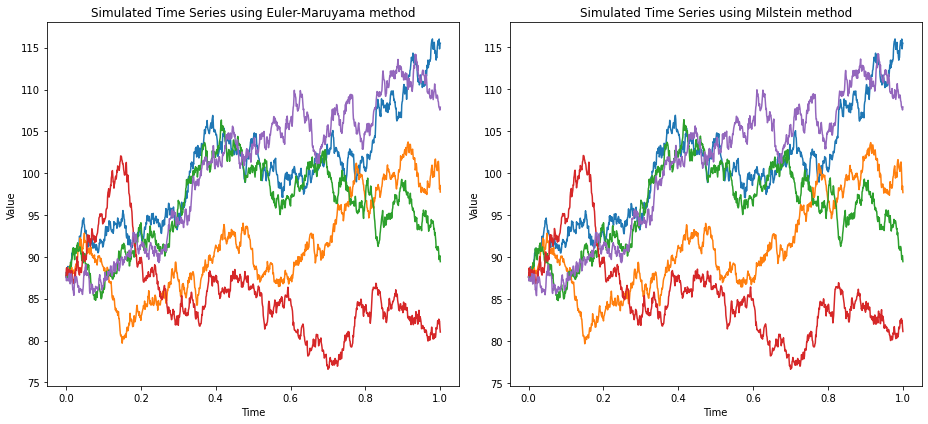

In [27]:
mc_simulator.plot_n_realisations(5)

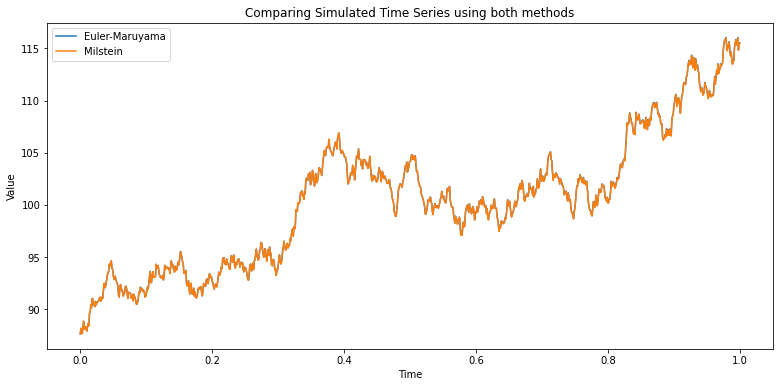

In [28]:
mc_simulator.comparing_ith_realisations(0)

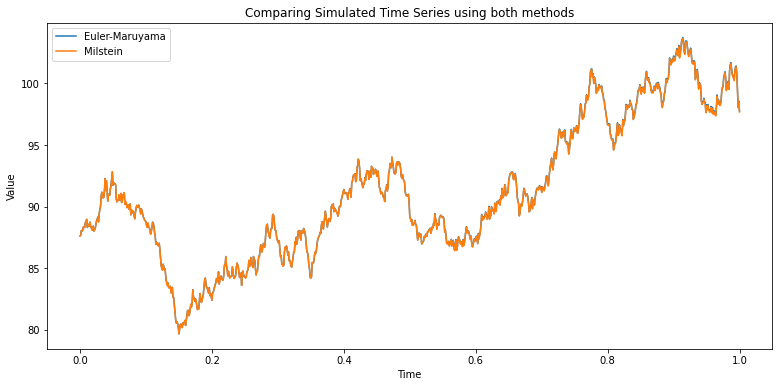

In [29]:
mc_simulator.comparing_ith_realisations(1)

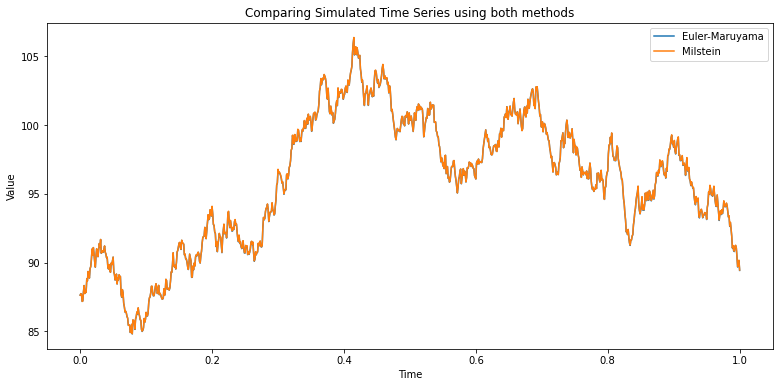

In [30]:
mc_simulator.comparing_ith_realisations(2)

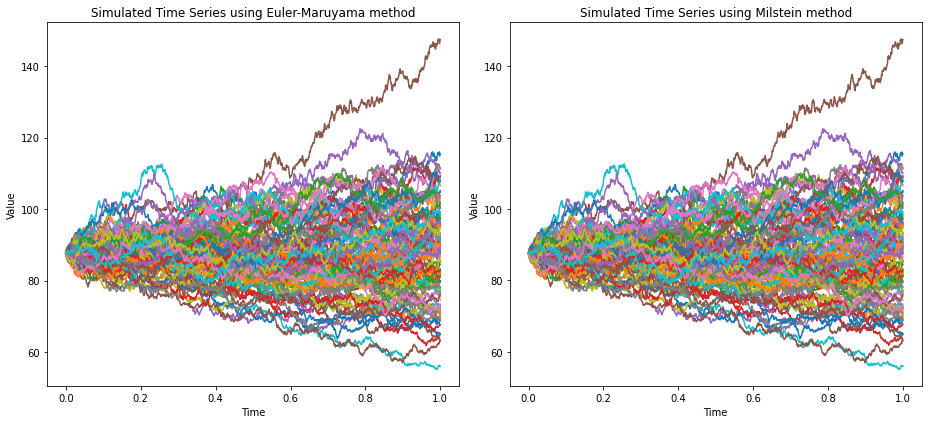

In [31]:
mc_simulator.plot_n_realisations(100)

# Barrier Options

1. up-and-in call option
1. up-and-out call option
1. down-and-in call option
1. down-and-out call option
1. up-and-in put option
1. up-and-out put option
1. down-and-in put option
1. down-and-out put option

In [27]:
class BarrierOption(MC_simulator_optimised):
    def __init__(self, S0, K, r, sigma, T, N, M, barrier_type, H_bound, L_bound):
        super().__init__(S0, K, r, sigma, T, N, M)
        self.barrier_type = barrier_type # int: corresponds to the indexes listed above
        self.H_bound = H_bound   # upper barrier
        self.L_bound = L_bound   # lower barrier
    
    def run_monte_carlo(self):
        print('Start running simulations...')
        # price the option
        EM_option_price = self.em_simulator.run_monte_carlo()
        M_option_price = self.mil_simulator.run_monte_carlo()

        return (EM_option_price, M_option_price)
    
    

In [29]:
# Parameters
S0 = 87.63  # Initial price
K = 100  # Strike price
r = 0.01  # Risk-free interest rate
sigma = 0.15  # volatility
T = 10  # Final time
N = 1000  # number of time steps
dt = T/N  # time step size
I = 1000  # number of simulations

barrier_option = BarrierOption(S0, K, r, sigma, T, N, I, 3,2,1)
(EM_option_price, M_option_price) = barrier_option.run_monte_carlo()
print("Euler-Maruyama: Estimated present value is %f" % EM_option_price)
print("Milstein: Estimated present value is %f" % M_option_price)

Start running simulations...



Euler-Maruyama: Estimated present value is 15.595524
Milstein: Estimated present value is 15.594471
